## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

## Clone old scenario and create split infrastructure scenario

In [3]:
ssp = "SSP5"

In [4]:
# this is to import scenario from data base and clone to local
base = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1', scenario="baseline_v0.13")
base_scen = base.clone(
    f"SSP_dev_{ssp}_v0.1_dac",
    "baseline_v0.13",
    f"{ssp}_dev for DAC",
    keep_solution=False, 
)
base_scen.check_out()

year_df = base_scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = base_scen.set("year")

base_scen.commit(comment=f"{ssp}_dev baseline with DAC scenario")
base_scen.set_as_default()

base_scen.solve(solve_options={'scaind': '1'}) # solve_options={'barcrossalg': '2','scaind':'1'}
base_scen.var("OBJ")["lvl"]

3100161.75

In [5]:
# this is to import scenario from data base and clone to local
scen = base_scen.clone(
    f"SSP_dev_{ssp}_v0.1_dac",
    "baseline_v0.13_dac-co2split",
    "dac baseline with split CO2 transmission and disposal",
    keep_solution=False, 
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")


## Split CO2 infrastructure
**1) Removing old setup:**

In [6]:
# REMOVE RELATIONS
# list of parameters to remove
params = ['relation_activity']

# list of technologies to remove
techs = ['co2_tr_dis', 'bco2_tr_dis',
         'bio_istig_ccs','bio_ppl_co2scr','eth_bio_ccs','h2_bio_ccs','liq_bio_ccs',
         'c_ppl_co2scr','cement_co2scr','coal_adv_ccs','g_ppl_co2scr','gas_cc_ccs',
         'h2_coal_ccs','h2_smr_ccs','igcc_ccs','meth_coal_ccs','meth_ng_ccs','syn_liq_ccs']
rels = ['co2_trans_disp','bco2_trans_disp','CO2_Emission_Global_Total', 'CO2_Emission',]

# removing parameters
for par in params:
    scen.remove_par(par, scen.par(par,{'technology':techs,'relation':rels}))
    
# REMOVE PIPELIENES
# list of parameters to remove
params = ['inv_cost','fix_cost','input','capacity_factor','technical_lifetime',
          'construction_time','abs_cost_activity_soft_up','growth_activity_lo',
          'level_cost_activity_soft_lo','level_cost_activity_soft_up','relation_activity',
          'var_cost','output','emission_factor','soft_activity_lo','soft_activity_up',
          'growth_activity_up','initial_activity_up']

# list of technologies to remove
pipes = ['co2_tr_dis', 'bco2_tr_dis']
# removing parameters
for par in params:
    scen.remove_par(par, scen.par(par,{'technology':pipes}))
    
# REMOVE SETS    
# removing daccs from technology set
scen.remove_set('technology',pipes)
scen.remove_set('relation',rels[0:2])


**2) Add new set of technologies:**

In [7]:
# add CO2_storage
scen.add_set('emission',"CO2_storage")

# add related technologies
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/co2infrastructure_data_ssp2dev.yaml'
add_tech(scen,filepath=filepath)

In [8]:
# removing some pipelines parameters
newpipesnstors = ['co2_stor','co2_tr_ld', 'co2_tr_sd']
pars2remove = ['var_cost','input','output','emission_factor','capacity_factor']
for par in pars2remove:
    df = scen.par(par,{'technology':newpipesnstors})
    df= df.loc[df['year_vtg'] != df['year_act']]
    scen.remove_par(par, df)

# removing excess year_act
pars2remove = ['output']
for par in pars2remove:
    df = scen.par(par,{'technology':techs})
    df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
    scen.remove_par(par, df)

In [9]:
# add daccs
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/daccs_setup_data_ssp2dev.yaml'
add_tech(scen,filepath=filepath)

In [10]:
# removing some parameters
newpipesnstors = ['co2_tr_sd','co2_stor']
pars2remove = ['emission_factor','capacity_factor','var_cost','input','output']
for par in pars2remove:
    df = scen.par(par,{'technology':newpipesnstors})
    df= df.loc[df['year_vtg'] != df['year_act']]
    scen.remove_par(par, df)

# removing excess year_act
pars2remove = ['capacity_factor','fix_cost','input','output']
techs = ['dac_lt', 'dac_ht']
for par in pars2remove:
    df = scen.par(par,{'technology':techs})
    df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
    scen.remove_par(par, df)
    
# adding relation_upper and _lower
nodes = [node for node in scen.set("node") if node != "World"]
rels = ["DAC_mpen_c"]
df_list = []
for rel in rels:
    for node in nodes:
        df = make_df("relation_upper",
                     relation=rel,
                     node_rel=node,
                     year_rel=list(sorted(set(act_years))),
                     unit = "-",
                     value = 0
                    )
        df_list = df_list + [df]
dfpar2add = pd.concat(df_list)
scen.add_par("relation_upper", dfpar2add)
scen.add_par("relation_lower", dfpar2add)

In [11]:
scen.commit(comment=f"{ssp} baseline scenario with dac and split CO2 infrastructure")
scen.set_as_default()

In [12]:
scen.solve(solve_options={'barcrossalg': '2','scaind':'0'}) # solve_options={'barcrossalg': '2','scaind':'1'}
scen.var("OBJ")["lvl"]

3100161.75

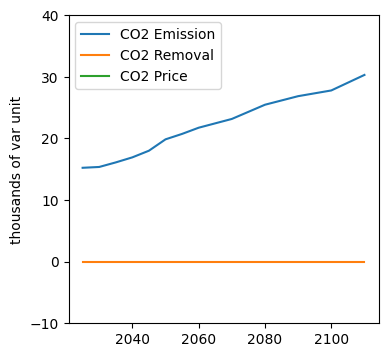

In [13]:
plotvars(scen)

## Run 1000f scenario

In [14]:
# this is to import scenario from data base and clone to local
co2bound_scen = scen.clone(
    f"SSP_dev_{ssp}_v0.1_dac",
    "1000f_v0.13_dac-co2split",
    "dac 1000f carbon budget with split CO2 transmission and disposal",
    keep_solution=False, 
)
co2bound_scen.check_out()

# add emission bound
co2bound_scen.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")

In [15]:
co2bound_scen.commit(comment=f"{ssp}_dev 1000f without DAC scenario")
co2bound_scen.set_as_default()

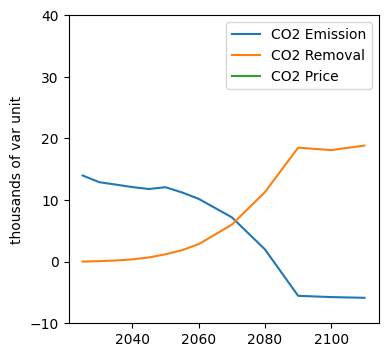

In [16]:
co2bound_scen.solve(solve_options={'scaind': '1'}) # solve_options={'barcrossalg': '2','scaind':'1'}
co2bound_scen.var("OBJ")["lvl"]
plotvars(co2bound_scen)

## Close connection

In [17]:
mp.close_db()